In [1]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import max_norm

import sys
import keras_tuner as kt

import torch
import torch.nn as nn
import torch.nn.functional as F

Code has been adjusted to utilize only a single CSV instead of all 12 to make training time more realistic. 

In [3]:
df = pd.read_csv("C:/Users/kelby/Desktop/Master's in AI/5-Deep Learning (DSCI-619)/2 - Regression - TensorFlow PyTorch/PRSA_Data/PRSA_Data1.csv")

# Display the merged dataset
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [4]:
print(df['station'].unique())

['Aotizhongxin']


In [5]:
df.tail()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
35059,35060,2017,2,28,19,12.0,29.0,5.0,35.0,400.0,95.0,12.5,1013.5,-16.2,0.0,NW,2.4,Aotizhongxin
35060,35061,2017,2,28,20,13.0,37.0,7.0,45.0,500.0,81.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Aotizhongxin
35061,35062,2017,2,28,21,16.0,37.0,10.0,66.0,700.0,58.0,10.8,1014.2,-13.3,0.0,NW,1.1,Aotizhongxin
35062,35063,2017,2,28,22,21.0,44.0,12.0,87.0,700.0,35.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Aotizhongxin
35063,35064,2017,2,28,23,19.0,31.0,10.0,79.0,600.0,42.0,8.6,1014.1,-15.9,0.0,NNE,1.3,Aotizhongxin


Imported all CSVs, checked unique station values to verify all 12 were imported and concatenated successfully. <br />
Dropped station column, as it isn't listed in the assignment. 

In [6]:
df.dtypes

No           int64
year         int64
month        int64
day          int64
hour         int64
PM2.5      float64
PM10       float64
SO2        float64
NO2        float64
CO         float64
O3         float64
TEMP       float64
PRES       float64
DEWP       float64
RAIN       float64
wd          object
WSPM       float64
station     object
dtype: object

In [7]:
df.isnull().sum(axis = 0)

No            0
year          0
month         0
day           0
hour          0
PM2.5       925
PM10        718
SO2         935
NO2        1023
CO         1776
O3         1719
TEMP         20
PRES         20
DEWP         20
RAIN         20
wd           81
WSPM         14
station       0
dtype: int64

This is an extremely high amount of null values. <br /> 
Went back and printed tail. With 420,767 rows, the null values should be negligable. 

In [8]:
df = df.drop('station', axis=1)
df = df.dropna()

In [9]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0


In [10]:
print(df['No'].value_counts().head())

No
1        1
23748    1
23761    1
23760    1
23759    1
Name: count, dtype: int64


Multiple counts of each "No" which means it was basically just an index for each spreadsheet prior to concatenation. 

In [11]:
df.drop(columns=['No'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [12]:
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0


The above steps were taken to remove duplicates from the 12 CSV files. The code remains, as I don't feel the index is necessary. 

### Converting categorical features to numerical

In [13]:
cat_features = ['wd']
num_features = pd.get_dummies(df[cat_features],drop_first=True).astype(int)
num_features.head()

,wd_ENE,wd_ESE,wd_N,wd_NE,wd_NNE,wd_NNW,wd_NW,wd_S,wd_SE,wd_SSE,wd_SSW,wd_SW,wd_W,wd_WNW,wd_WSW
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
print(df.shape)
print(num_features.shape)

(31815, 16)
(31815, 15)


Rows line up, so we are good to replace the categorical feature with the numerical features. 

In [15]:
df = df.drop(cat_features,axis=1)
df = pd.concat([df, num_features], axis=1)
df.head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,...,wd_NNW,wd_NW,wd_S,wd_SE,wd_SSE,wd_SSW,wd_SW,wd_W,wd_WNW,wd_WSW
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,...,1,0,0,0,0,0,0,0,0,0
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,...,0,0,0,0,0,0,0,0,0,0
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,...,1,0,0,0,0,0,0,0,0,0
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,...,0,1,0,0,0,0,0,0,0,0
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
numerical = ['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
np.round(df[numerical].corr(), decimals=2)

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
year,1.00,-0.18,0.00,0.00,-0.03,-0.08,-0.18,-0.11,0.06,0.09,-0.16,0.25,-0.22,-0.00,0.14
month,-0.18,1.00,0.01,0.00,0.02,-0.04,-0.27,0.11,0.05,-0.09,0.18,-0.04,0.32,0.02,-0.16
day,0.00,0.01,1.00,-0.00,0.01,0.03,-0.02,0.02,-0.02,0.01,0.03,0.01,0.04,-0.00,-0.02
hour,0.00,0.00,-0.00,1.00,-0.01,0.02,0.00,-0.05,-0.05,0.30,0.14,-0.04,-0.01,0.01,0.15
PM2.5,-0.03,0.02,0.01,-0.01,1.00,0.88,0.49,0.69,0.79,-0.17,-0.13,-0.01,0.13,-0.02,-0.29
PM10,-0.08,-0.04,0.03,0.02,0.88,1.00,0.48,0.65,0.68,-0.15,-0.11,-0.03,0.06,-0.03,-0.19
SO2,-0.18,-0.27,-0.02,0.00,0.49,0.48,1.00,0.44,0.54,-0.20,-0.35,0.20,-0.28,-0.04,-0.11
NO2,-0.11,0.11,0.02,-0.05,0.69,0.65,0.44,1.00,0.69,-0.51,-0.24,0.09,0.06,-0.04,-0.49
CO,0.06,0.05,-0.02,-0.05,0.79,0.68,0.54,0.69,1.00,-0.33,-0.36,0.21,-0.10,-0.02,-0.28
O3,0.09,-0.09,0.01,0.30,-0.17,-0.15,-0.20,-0.51,-0.33,1.00,0.59,-0.42,0.29,0.02,0.34


From the correlations shown above, we can see that PM2.5 has heavy correlation with PM10, SO2, NO2, and CO. <br /> 
We can also see that even minute details have correlations with others, positive or negative. 

### Train Test Split

In [17]:
X = df.drop('PM2.5',axis=1)
y = df['PM2.5']

#Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

### Normalize the data

In [18]:
scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
print(f'Min: {X_train.min()}, Max: {X_train.max()}')

Min: 0.0, Max: 1.0000000000000002


In [20]:
X_train.shape

(25452, 29)

Verified values are between 0 and 1. 

# TensorFlow

In [21]:
tf_model = keras.Sequential()
tf_model.add(layers.Dense(29, activation='relu'))
tf_model.add(layers.Dense(20, activation='relu'))
tf_model.add(layers.Dense(10, activation='relu'))
tf_model.add(layers.Dense(1))

tf_model.compile(optimizer='adam',loss='mse')

In [22]:
%%time

tf.random.set_seed(1)

with tf.device('/GPU:0'):
    history = tf_model.fit(
        x=X_train, y=y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), verbose = 0
    )


CPU times: total: 7min 40s
Wall time: 7min 12s


In [23]:
train_hist = pd.DataFrame(history.history)
train_hist['epoch'] = history.epoch

train_hist.tail()

,loss,val_loss,epoch
95,453.332001,455.700378,95
96,452.062866,462.637146,96
97,454.228455,454.107544,97
98,452.989502,482.443298,98
99,451.536194,452.404968,99


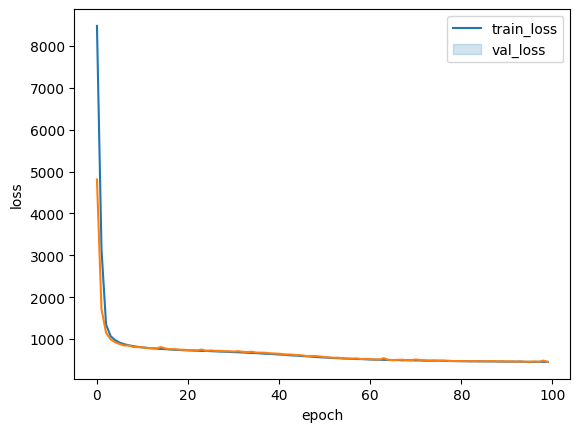

In [24]:
#Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_hist)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_hist)
#Add legends
plt.legend(labels=['train_loss', 'val_loss'])

Based on the above plot, it looks like training loss continues to shrink while validation loss plateaus. <br /> 
There is likely some overfitting occurring. We can check and verify by using more epochs. 

In [23]:
%%time

tf.random.set_seed(1)

history = tf_model.fit(
    x=X_train, y=y_train, batch_size=64, epochs=1000, validation_data=(X_test, y_test), verbose = 0
)


CPU times: total: 18min 52s
Wall time: 13min 35s


In [24]:
train_hist = pd.DataFrame(history.history)
train_hist['epoch'] = history.epoch

train_hist.tail()

,loss,val_loss,epoch
995,493.470886,496.883972,995
996,493.550873,503.935760,996
997,492.396515,497.698639,997
998,492.432343,499.797607,998
999,492.996307,516.742981,999


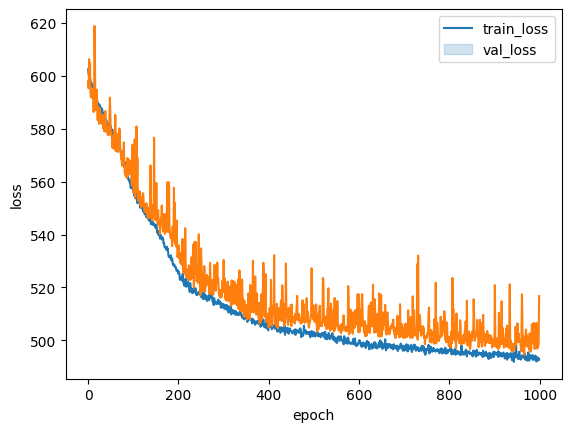

In [25]:
#Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_hist)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_hist)
#Add legends
plt.legend(labels=['train_loss', 'val_loss'])

Above, we prove that the models are slightly overfitting on the training data. 

In [26]:
def model_builder(hp):
    model = keras.Sequential()
 
    hp_units1 = hp.Int('units_1', min_value = 20, max_value = 50, step = 5)
    hp_units2 = hp.Int('units_2', min_value = 5, max_value = 10, step = 1)
    hp_dropout1 = hp.Float('rate1', min_value = 0.2, max_value = 0.8, step = 0.1)
    hp_dropout2 = hp.Float('rate2', min_value = 0.2, max_value = 0.8, step = 0.1)
    hp_learning_rate = hp.Float('lr', min_value=0.001, max_value=0.01, step=0.001)
    
    model.add(layers.Dense(units = hp_units1, activation = 'relu'))
    model.add(Dropout(rate = hp_dropout1))

    model.add(layers.Dense(units = hp_units2, activation = 'relu'))
    model.add(Dropout(rate = hp_dropout2))

    model.add(layers.Dense(1))

    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = 'mse', 
                metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError()])

    return model

In [27]:
tuner = kt.Hyperband(model_builder, #Specify the model
                     objective = 'val_loss', #Specify the objective funciton
                     max_epochs = 100, #Specify the maximum epochs
                     directory = 'Project2', #Specify the file path
                     project_name = 'pm25_pred')

In [29]:
# Perform search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Trial 254 Complete [00h 03m 49s]
val_loss: 811.9788818359375

Best val_loss So Far: 520.3095703125
Total elapsed time: 01h 43m 26s


In [30]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters found: {best_hps.values}")

Best hyperparameters found: {'units_1': 45, 'units_2': 9, 'rate1': 0.2, 'rate2': 0.30000000000000004, 'lr': 0.004, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 4, 'tuner/round': 4, 'tuner/trial_id': '0143'}


In [31]:
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
796/796 [==============================] - 2s 3ms/step - loss: 4087.2742 - mean_squared_error: 4087.2742 - root_mean_squared_error: 63.9318 - val_loss: 1160.9454 - val_mean_squared_error: 1160.9454 - val_root_mean_squared_error: 34.0726
Epoch 2/50
796/796 [==============================] - 2s 3ms/step - loss: 2154.2878 - mean_squared_error: 2154.2878 - root_mean_squared_error: 46.4143 - val_loss: 1128.1188 - val_mean_squared_error: 1128.1188 - val_root_mean_squared_error: 33.5875
Epoch 3/50
796/796 [==============================] - 2s 3ms/step - loss: 2080.0159 - mean_squared_error: 2080.0159 - root_mean_squared_error: 45.6072 - val_loss: 959.6277 - val_mean_squared_error: 959.6277 - val_root_mean_squared_error: 30.9779
Epoch 4/50
796/796 [==============================] - 2s 3ms/step - loss: 2028.8167 - mean_squared_error: 2028.8167 - root_mean_squared_error: 45.0424 - val_loss: 991.4487 - val_mean_squared_error: 991.4487 - val_root_mean_squared_error: 31.4873
Epoch 5/50
7

In [32]:
y_pred = best_model.predict(X_test)

199/199 [==============================] - 1s 2ms/step


In [35]:
print(f"The mean square error is {mean_squared_error(y_test, y_pred):.4f}")
print(f"The root mean square error is {root_mean_squared_error(y_test, y_pred):.4f}")
print(f"The mean absolute error is {mean_absolute_error(y_test, y_pred):.4f}")

The mean square error is 734.7232
The root mean square error is 27.1058
The mean absolute error is 18.8927


# PyTorch

In [24]:
X_train = torch.tensor(X_train.astype(np.float32))
y_train = torch.tensor(y_train.values.astype(np.float32).reshape(-1,1))

In [26]:
y_train.shape

torch.Size([25452, 1])

In [25]:
X_train.shape

torch.Size([25452, 29])

In [56]:
input_size = X_train.shape[1]
output_size = y_train.shape[1]
#specify the number of neuron for the first layer
hidden_size = [20, 10]
print(input_size)
print(output_size)

#convert numpy to tensor from_numpy
X_test = torch.from_numpy(X_test.astype(np.float32))

29
1


AttributeError: 'Tensor' object has no attribute 'astype'

In [95]:
class LinearRegressionModel(torch.nn.Module):
    def __init__(self, input_size,  hidden_size, output_size, dropout_rate):
        super(LinearRegressionModel, self).__init__()
        self.hidden1 = torch.nn.Linear(input_size, hidden_size[0]) 
        self.hidden2 = torch.nn.Linear(hidden_size[0], hidden_size[1]) 
        self.hidden3 = torch.nn.Linear(hidden_size[1], output_size) 
        
        self.dropout1 = torch.nn.Dropout(dropout_rate)
        self.dropout2 = torch.nn.Dropout(dropout_rate)
    #overide forward function, apply dropout after each activation
    def forward(self, x):
        x = F.relu(self.hidden1(x))  
        x = self.dropout1(x)
        
        x = F.relu(self.hidden2(x))
        x = self.dropout2(x)
        
        y_pred = self.hidden3(x)            
        return y_pred

In [104]:
pt_model = LinearRegressionModel(input_size, hidden_size, output_size, dropout_rate=0.1)
l = nn.MSELoss()
optimizer = torch.optim.Adam(pt_model.parameters(), lr=0.05)

In [105]:
%%time

torch.manual_seed(1)
np.random.seed(1)

num_epochs = 1000

train_loss = [None]*num_epochs
valadition_loss = [None]*num_epochs
for epoch in range(num_epochs):
    #forward pass
    y_pred = pt_model(X_train.requires_grad_())

    #calculate the loss
    loss= l(y_pred, y_train)
    
    #Set gradients to zero
    optimizer.zero_grad()
    
    #backward pass
    loss.backward()

    #update the weights
    optimizer.step()
        
    y_pred = pt_model(X_test).detach().numpy()
    val_loss = mean_squared_error(y_test,y_pred)
    train_loss[epoch] = loss.item()
    valadition_loss[epoch] = val_loss
    #print loss every 10 epochs
    if epoch % 100 == 0:
        print(f"epoch {epoch}, loss = {loss.item():.4f} and val_loss = {val_loss:.4f}")

epoch 0, loss = 13156.6816 and val_loss = 13331.3343
epoch 100, loss = 1511.7363 and val_loss = 1448.3916
epoch 200, loss = 1207.6075 and val_loss = 1233.3070
epoch 300, loss = 1185.4115 and val_loss = 1205.5179
epoch 400, loss = 1121.4052 and val_loss = 1180.1131
epoch 500, loss = 1126.1914 and val_loss = 1151.2058
epoch 600, loss = 1120.9086 and val_loss = 1124.5420
epoch 700, loss = 1089.7617 and val_loss = 1145.7702
epoch 800, loss = 1111.9989 and val_loss = 1128.9087
epoch 900, loss = 1089.0173 and val_loss = 1134.3740
CPU times: total: 1min 48s
Wall time: 13.6 s


In [106]:
#Convert the train and validation loss to a df
trainhist = pd.DataFrame({'train_loss': train_loss, 'val_loss': valadition_loss, 'epoch':np.arange(num_epochs)})
#Look at the latest performance
trainhist.tail()

,train_loss,val_loss,epoch
995,1049.936646,1123.245464,995
996,1055.218994,1096.147045,996
997,1050.984375,1098.835703,997
998,1036.293701,1092.891104,998
999,1031.503052,1088.717011,999


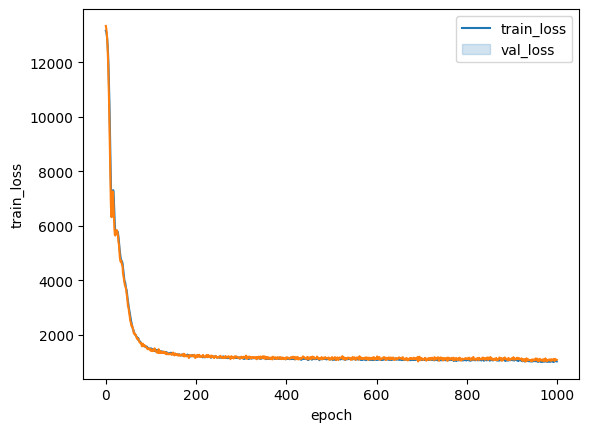

In [107]:
#Plot train loss
sns.lineplot(x='epoch', y ='train_loss', data =trainhist)
#Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =trainhist)
#Add legends
plt.legend(labels=['train_loss', 'val_loss'])

My PyTorch model leans towards overfitting, as we see the validation loss plateau as training loss continues to shrink. <br />
I adjusted this by incorporating dropout rate, but with that change, validation loss increased. <br />
In conclusion, the model initially overfits but fine-tuning parameters could still net us better test results. 